# Ejercicio de K-means
Realizaremos un ejercicio de prueba para comprender como funciona este algoritmo

Como ejemplo utilizaremos de entradas un conjunto de datos en el que se analizaban rasgos de la personalidad de usuarios de Twitter. He filtrado a 140 “famosos” del mundo en diferentes areas: deporte, cantantes, actores, etc. Basado en una metodología de psicología conocida como “Ocean: The Big Five” tendemos como características de entrada:

* usuario (el nombre en Twitter)
* “op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte
* “co” =Conscientiousness – grado de orden, prolijidad, organización
* “ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social
* “ag” = Agreeableness – grado de empatía con los demás, temperamento
* “ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.
* Wordcount – Cantidad promedio de palabras usadas en sus tweets
* Categoria – Actividad laboral del usuario (actor, cantante, etc.)

Utilizaremos el algoritmo K-means para que agrupe estos usuarios -no por su actividad laboral- si no, por sus similitudes en la personalidad. Si bien tenemos 8 columnas de entrada, __sólo utilizaremos 3__ en este ejemplo, de modo que podamos ver en un gráfico tridimensional -y sus proyecciones a 2D- los grupos resultantes. Pero para casos reales, podemos utilizar todas las dimensiones que necesitemos. Una de las hipótesis que podríamos tener es: “Todos los cantantes tendrán personalidad parecida” (y así con cada rama laboral). Pues veremos si lo probamos, o por el contrario, los grupos no están relacionados necesariamente con la actividad de estas Celebridades.

# Objetivo
__En este notebook intentaremos agrupar usuario de Twitter de acuerdo a su personalidad__

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

## Cargamos los datos de entrada del archivo csv

In [2]:
dataframe = pd.read_csv(r"analisis.csv")
dataframe.head()

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [3]:
dataframe.describe()

,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678867,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000


El archivo contiene diferenciadas 9 categorías -actividades laborales- que son:

1. Actor/actriz
2. Cantante
3. Modelo
4. Tv, series
5. Radio
6. Tecnología
7. Deportes
8. Politica
9. Escritor

Para saber cuantos registros tenemos de cada uno hacemos:

In [4]:
# Vemos cuantos usuarios hay de cada categoria
print(dataframe.groupby('categoria').size())

categoria
1    27
2    34
3     9
4    19
5     4
6     8
7    17
8    16
9     6
dtype: int64


Como vemos tenemos 34 cantantes, 27 actores, 17 deportistas, 16 políticos, etc.

## Visualizamos los datos
Veremos graficamente nuestros datos para tener una idea de la dispersión de los mismos:

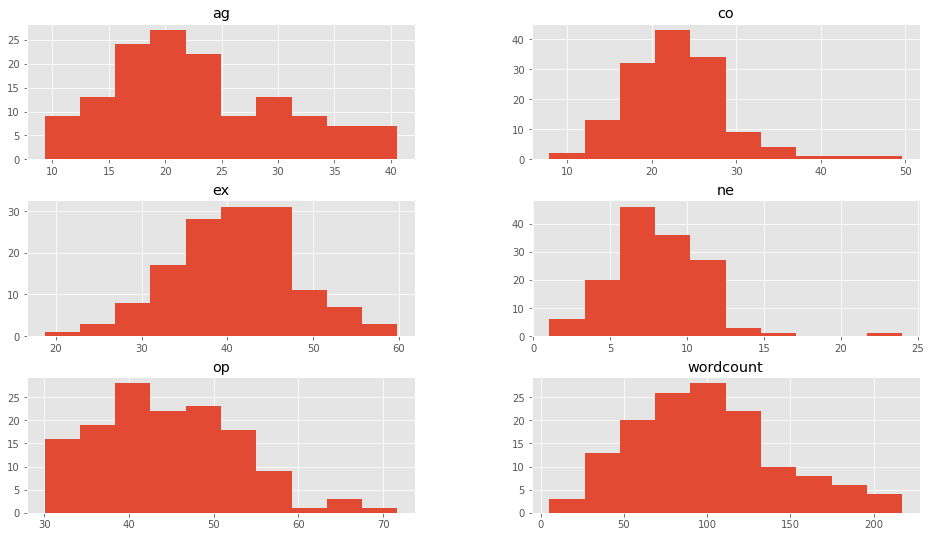

In [5]:
dataframe.drop(['categoria'],1).hist()
plt.show()

En este caso seleccionamos 3 dimensiones: op, ex y ag y las cruzamos para ver si nos dan alguna pista de su agrupación y la relación con sus categorías.

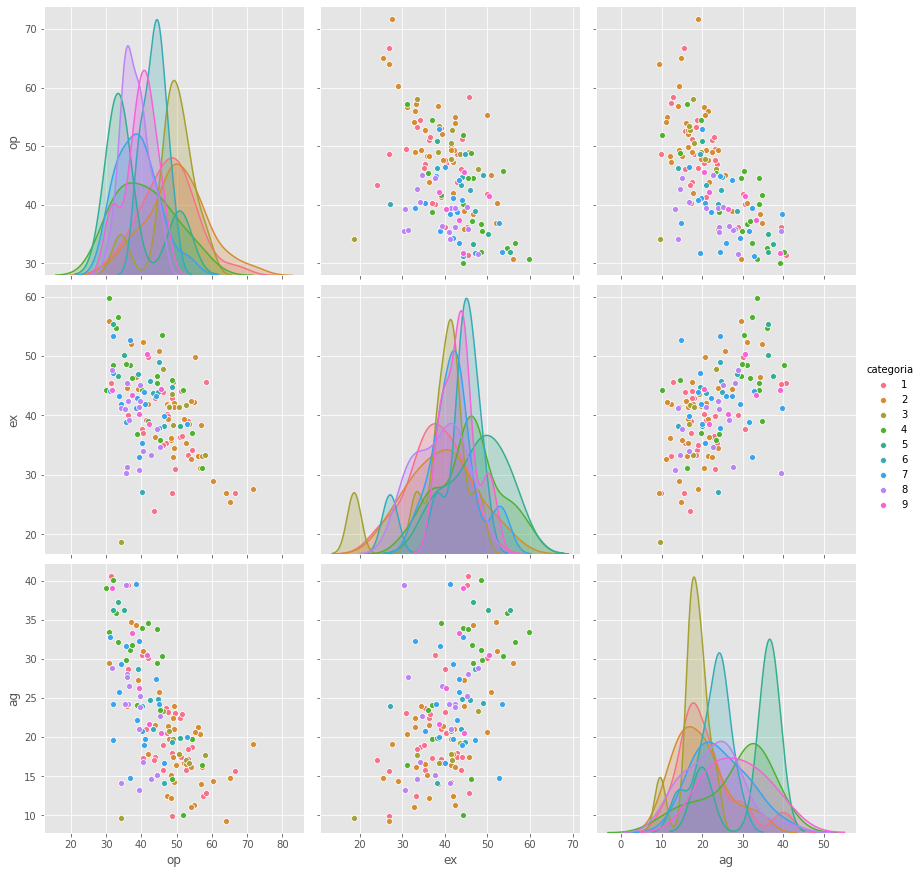

In [6]:
sb.pairplot(dataframe.dropna(), hue='categoria',height=4,vars=["op","ex","ag"],kind='scatter')

Revisando la gráfica no parece que haya algún tipo de agrupación o correlación entre los usuarios y sus categorías.

## Creamos el modelo
Concretamos la estructura de datos que utilizaremos para alimentar el algoritmo. Como se ve, sólo cargamos las columnas op, ex y ag en nuestra variable X.

In [7]:
#Para el ejercicio, sólo seleccionamos 3 dimensiones, para poder graficarlo
X = np.array(dataframe[["op","ex","ag"]])
y = np.array(dataframe['categoria'])
X.shape

(140, 3)

Ahora veremos una gráfica en 3D con 9 colores representando las categorías.

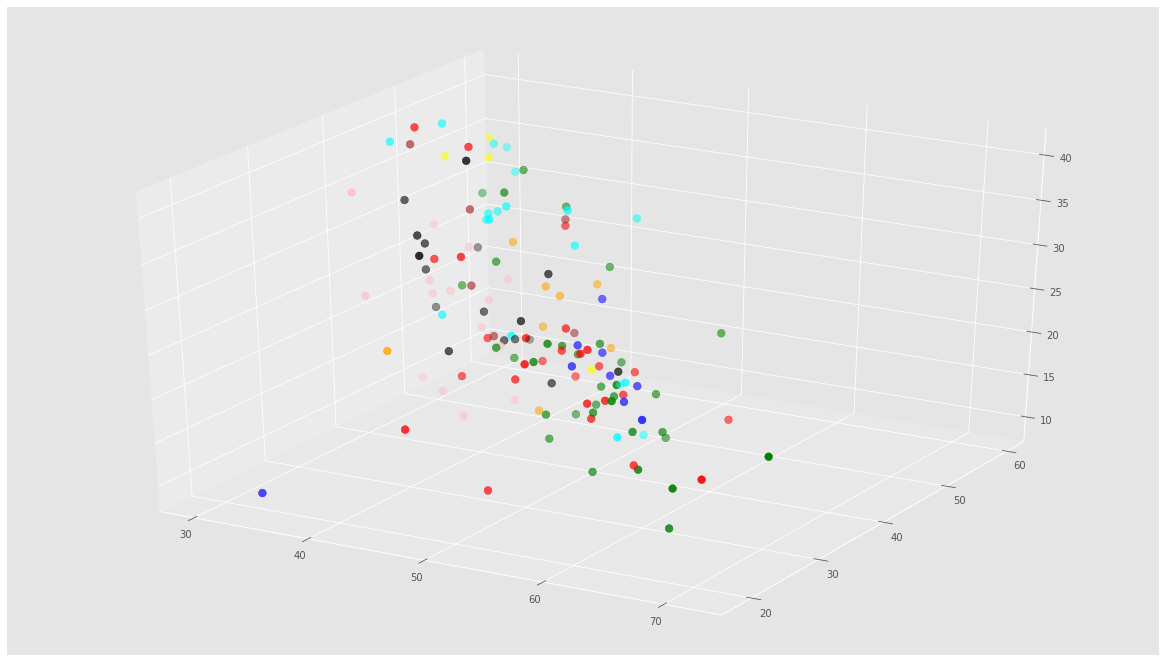

In [8]:
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
#NOTA: asignamos la posición cero del array repetida pues las categorias comienzan en id 1. 
asignar=[]
for row in y:
    asignar.append(colores[row])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)

Veremos si con K-means, podemos “pintar” esta misma gráfica de otra manera, con clusters diferenciados.

# Buscamos el valor K
Vamos a hallar el valor de K haciendo una gráfica e intentando hallar el “punto de codo” que comentábamos antes. Este es nuestro resultado:

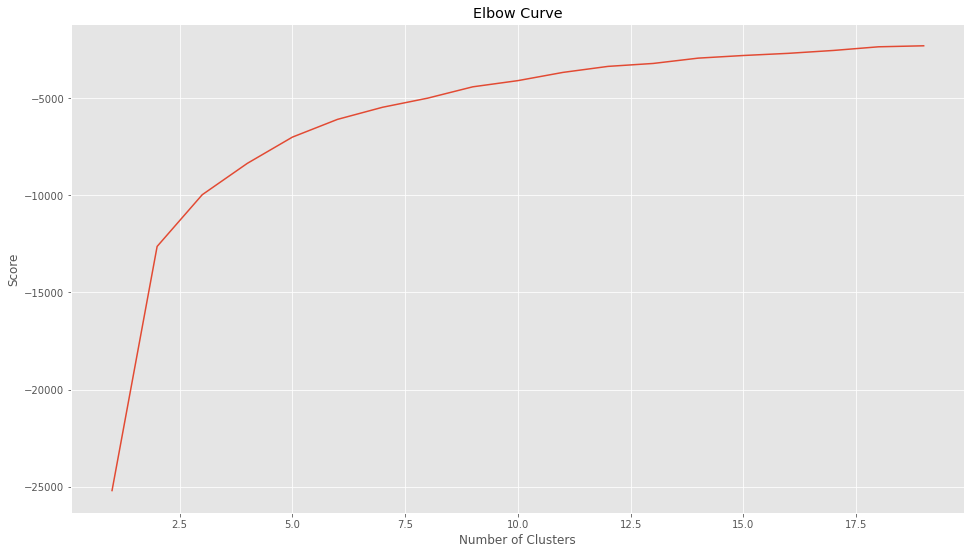

In [9]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Realmente la curva es bastante “suave”. Considero a 5 como un buen número para K. Según vuestro criterio podría ser otro.

# Ejecutamos K-Means
Ejecutamos el algoritmo para 5 clusters y obtenemos las etiquetas y los centroids.

In [10]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[58.58657531 31.02839375 15.6120435 ]
 [39.55874337 44.81190669 24.291027  ]
 [35.39154169 47.17372597 34.50044186]
 [49.99285115 40.87133549 17.47411785]
 [42.66891482 33.31008136 21.11530482]]


Ahora veremos esto en una gráfica 3D con colores para los grupos y veremos si se diferencian: (las estrellas marcan el centro de cada cluster)

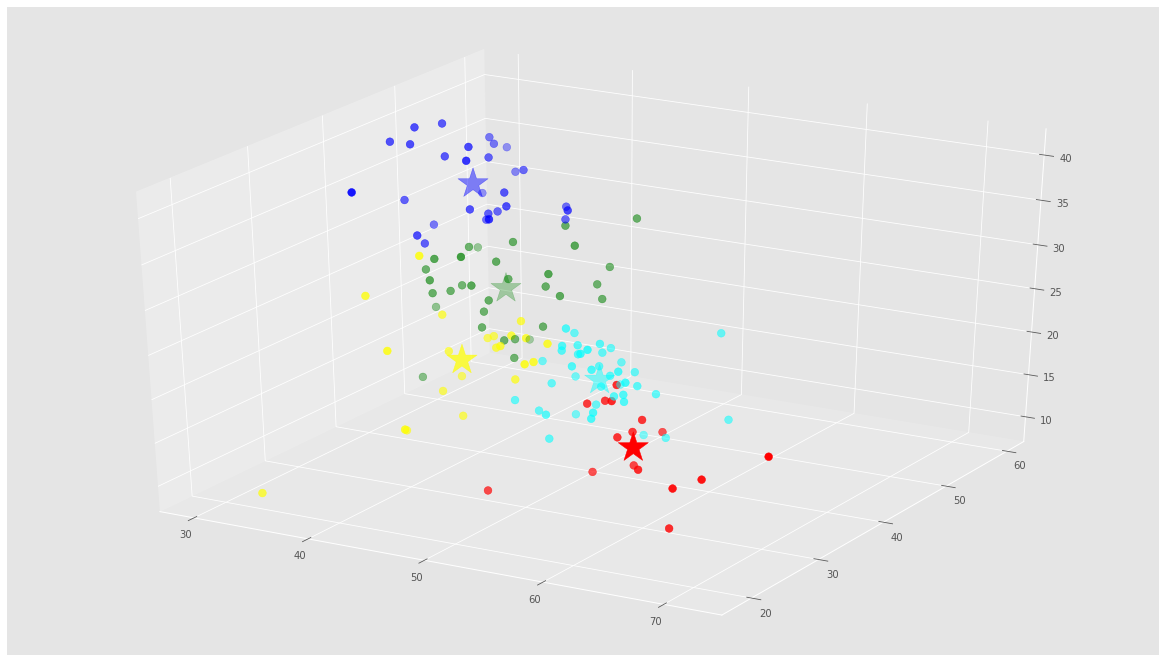

In [11]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

Aqui podemos ver que el Algoritmo de K-Means con K=5 ha agrupado a los 140 usuarios Twitter por su personalidad, teniendo en cuenta las 3 dimensiones que utilizamos: Openess, Extraversion y Agreeablenes. Pareciera que no hay necesariamente una relación en los grupos con sus actividades de Celebrity.

Haremos 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D para que nos ayude a visualizar los grupos y su clasificación:

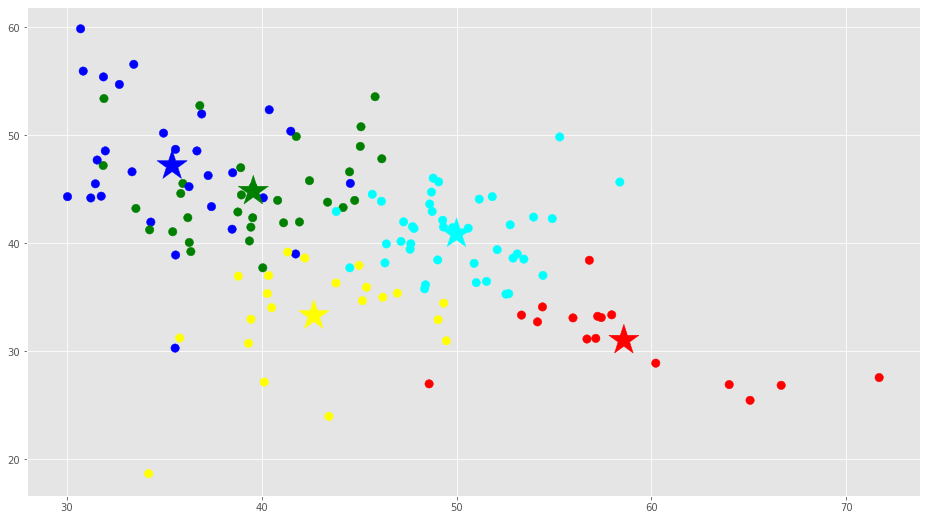

In [12]:
# Hacemos una proyección a 2D con los diversos ejes 
f1 = dataframe['op'].values
f2 = dataframe['ex'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

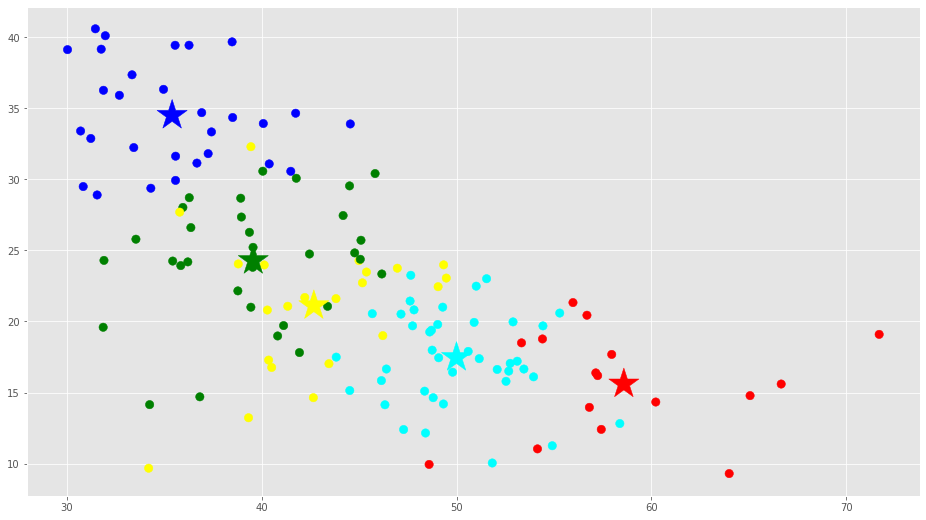

In [13]:
# Hacemos una proyección a 2D con los diversos ejes 
f1 = dataframe['op'].values
f2 = dataframe['ag'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

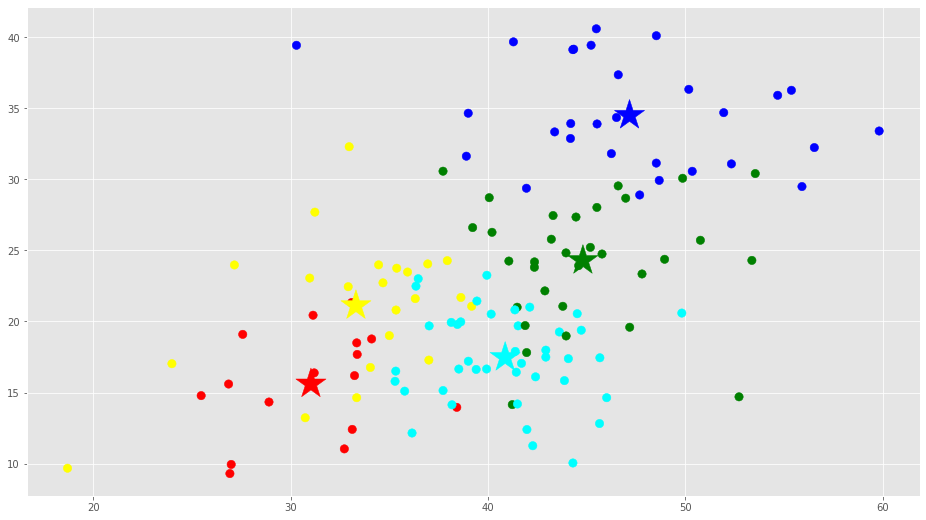

In [14]:
f1 = dataframe['ex'].values
f2 = dataframe['ag'].values

'''
# este codigo comentado agrega las categorias sobre cada punto
for label, x, y in zip(dataframe['categoria'].values, f1, f2):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
'''
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

En estas gráficas vemos que están bastante bien diferenciados los grupos.

Podemos ver cada uno de los clusters cuantos usuarios tiene:

In [15]:
# contamos cuantos usuarios hay en cada grupo
copy =  pd.DataFrame()
copy['usuario']=dataframe['usuario'].values
copy['categoria']=dataframe['categoria'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,16
1,green,32
2,blue,29
3,cyan,41
4,yellow,22


Y podemos ver la diversidad en rubros laborales de cada uno. Por ejemplo en el grupo 0 (rojo), vemos que hay de todas las actividades laborales aunque predominan de actividad 1 y 2 correspondiente a Actores y Cantantes con 11 y 15 famosos.

In [16]:
# Veamos cuantos usuarios en cada categoria hay en el grupo 0
group_referrer_index = copy['label'] ==0
group_referrals = copy[group_referrer_index]

diversidadGrupo =  pd.DataFrame()
diversidadGrupo['categoria']=[0,1,2,3,4,5,6,7,8,9]
diversidadGrupo['cantidad']=group_referrals.groupby('categoria').size()
diversidadGrupo

,categoria,cantidad
0,0,NaN
1,1,5.0
2,2,9.0
3,3,1.0
4,4,1.0
5,5,NaN
6,6,NaN
7,7,NaN
8,8,NaN
9,9,NaN


De categoría 3 “modelos” hay 6 sobre un total de 9.

Y como extra imprimiremos la información de esos 6 sujetos

In [17]:
#imprimimos en pantalla los usuarios con categoria 2 del grupo
for index, row in group_referrals.iterrows():
    if row["categoria"] == 3:
        print (row["usuario"], row["categoria"],row["label"])

victoriabeckham 3 0


Buscaremos los usuarios que están más cerca a los centroids de cada grupo que podríamos decir que tienen los rasgos de personalidad característicos que representan a cada cluster:

In [18]:
#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

array([ 82, 107, 121,  21,  91], dtype=int64)

In [19]:
users=dataframe['usuario'].values
for row in closest:
    print(users[row])

JudgeJudy
Pablo_Iglesias_
SerranoIsmael
carmenelectra
kobebryant


En los centros vemos que tenemos una modelo, un político, presentadora de Tv, locutor de Radio y un deportista.

# Clasificación de nuevos registros
Y finalmente podemos agrupar y etiquetar nuevos usuarios twitter con sus características y clasificarlos. Vemos el ejemplo con el usuario de David Guetta y nos devuelve que pertenece al grupo 2 (cantante).

In [20]:
X_new = np.array([[45.92,57.74,15.66]]) #davidguetta personality traits
new_labels = kmeans.predict(X_new)
print(new_labels)

#NOTA: en el array podemos poner más de un array para evaluar a varios usuarios nuevos a la vez

[1]


NOTA FINAL: Los resultados obtenidos pueden varias de ejecución en ejecución pues al inicializar aleatoriamente los centroids, podemos obtener grupos distintos o los mismos pero en distinto orden y color